In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import timedelta

Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [2]:
from itertools import tee, islice, chain

def neighbors(iterable):
    # Write generator function which yields 
    # previous, current and next values in iterable list.
    # ... type your code here ...
    for i in range(len(list(iterable))):
        if i == 0:
            prv, cur, nxt = [None, iterable[0], iterable[1]]
        elif i == (len(list(iterable))-1):
            prv, cur, nxt = [iterable[i-1], iterable[i] , None]
        else:    
            prv, cur, nxt = [iterable[i-1], iterable[i] , iterable[i+1]]
        yield prv, cur, nxt

In [3]:
iterable = range(3)
for i in range(len(list(iterable))):
        
        if i == 0:
            prv, cur, nxt = [None, iterable[0], iterable[1]]
        elif i == (len(list(iterable))-1):
            prv, cur, nxt = [iterable[i-1], iterable[i] , None]
        else:    
            prv, cur, nxt = [iterable[i-1], iterable[i] , iterable[i+1]]
        print (prv,cur, nxt)

None 0 1
0 1 2
1 2 None


In [4]:
for i in neighbors(iterable):
    print(i)

(None, 0, 1)
(0, 1, 2)
(1, 2, None)


In [5]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert next(test_neighbors) == (None, 0, 1)

test_neighbors()

    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [6]:
df = pd.read_csv("dataset.csv", parse_dates=["dttm"])
drivers_list = df.driver_id.unique()

In [7]:
big_list = []
for i in drivers_list:
  
    df1 = df[df['driver_id'] == i]
    
    list1 = []
    for j in df1.values:
        list1.append((j[0], j[2]))
    big_list.append([i, list1])

In [8]:
df_grouped = pd.DataFrame(big_list, columns=['driver_id', 'driver_info'])

In [9]:
df_grouped.head()

,driver_id,driver_info
0,8f174ffd446c456eaf3cca0915d0368d,"[(free, 2018-02-18 20:51:22.620339), (enroute,..."
1,dc66190e523943f5a83bdd393587439c,"[(free, 2018-02-18 20:02:47.620339), (enroute,..."
2,17833e71aa58494ea0cb0a53be840c4e,"[(free, 2018-02-18 20:19:26.620339), (enroute,..."
3,63f6aaaf48844d1e83e9fc78716c601e,"[(free, 2018-02-18 20:52:11.620339), (enroute,..."
4,78938964fed443cf85879cbf71c6ea56,"[(free, 2018-02-18 20:08:57.620339), (busy, 20..."


    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.

In [10]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        if k == None:
            delta = None 
        else:
            delta = (k[1]- j[1])
            delta = delta.seconds
              
        driver_info_updated.append ( (j[0], j[1], delta))
        
    return driver_info_updated

In [11]:
sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                      ("busy", datetime(2018, 4, 2, 1, 3)),
                      ("busy", datetime(2018, 4, 2, 1, 4)), ]

In [12]:
for i, j, k in neighbors(sample_driver_info):
    print(i,j,k)

None ('free', datetime.datetime(2018, 4, 2, 0, 19)) ('busy', datetime.datetime(2018, 4, 2, 1, 3))
('free', datetime.datetime(2018, 4, 2, 0, 19)) ('busy', datetime.datetime(2018, 4, 2, 1, 3)) ('busy', datetime.datetime(2018, 4, 2, 1, 4))
('busy', datetime.datetime(2018, 4, 2, 1, 3)) ('busy', datetime.datetime(2018, 4, 2, 1, 4)) None


In [13]:
calc_status_duration(sample_driver_info)

[('free', datetime.datetime(2018, 4, 2, 0, 19), 2640),
 ('busy', datetime.datetime(2018, 4, 2, 1, 3), 60),
 ('busy', datetime.datetime(2018, 4, 2, 1, 4), None)]

In [14]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

In [15]:
df_grouped["driver_info"] = df_grouped.driver_info.apply(calc_status_duration)

In [16]:
df_grouped.head()

,driver_id,driver_info
0,8f174ffd446c456eaf3cca0915d0368d,"[(free, 2018-02-18 20:51:22.620339, 1470), (en..."
1,dc66190e523943f5a83bdd393587439c,"[(free, 2018-02-18 20:02:47.620339, 5126), (en..."
2,17833e71aa58494ea0cb0a53be840c4e,"[(free, 2018-02-18 20:19:26.620339, 4884), (en..."
3,63f6aaaf48844d1e83e9fc78716c601e,"[(free, 2018-02-18 20:52:11.620339, 700), (enr..."
4,78938964fed443cf85879cbf71c6ea56,"[(free, 2018-02-18 20:08:57.620339, 674), (bus..."


In [17]:
df_grouped[df_grouped["driver_id"] == '63f6aaaf48844d1e83e9fc78716c601e'].driver_info.values

array([list([('free', Timestamp('2018-02-18 20:52:11.620339'), 700), ('enroute', Timestamp('2018-02-18 21:03:51.620339'), 1808), ('free', Timestamp('2018-02-18 21:33:59.620339'), None)])],
      dtype=object)

    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

In [18]:
def ifnull(var, val):
      if var is None:
        return val
      return var

In [19]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    count_free = []
    count_ontrip = []
    count_enroute = []

    for i, j, k in neighbors(driver_info):
    
        a = ("", 0, 0.)
        i = ifnull(i, a)
        k = ifnull(k, a)
        j = ifnull(j, a)
        
        if i[0]== "free" and k[0]=="free" and j[2] <= TIMEOUT:
       
            count_free.append(i[2])
            count_free.append(k[2])

        elif i[0] == "free" and k[0]!="free" and ifnull(j[2], 0)> TIMEOUT:

            count_free.append(ifnull(i[2],0))
        elif i[0] == "ontrip":
            count_ontrip.append(i[2])
        elif i[0] == "enroute" and j[0]!="free":
            count_enroute.append(i[2])
    try:
        z = [(sum(count_ontrip), sum(count_ontrip)/(sum(count_free)+sum(count_enroute)+sum(count_ontrip)))]
    except:
        z = 0
    return z

In [20]:
# Check if test passes
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()

In [21]:
df_grouped["driver_info"] = df_grouped.driver_info.apply(collapse_statuses)

In [22]:
df_grouped.head()

,driver_id,driver_info
0,8f174ffd446c456eaf3cca0915d0368d,"[(56956, 0.21637433565450614)]"
1,dc66190e523943f5a83bdd393587439c,"[(61849, 0.247798424641618)]"
2,17833e71aa58494ea0cb0a53be840c4e,"[(14247, 0.24621526337619246)]"
3,63f6aaaf48844d1e83e9fc78716c601e,0
4,78938964fed443cf85879cbf71c6ea56,"[(38899, 0.21691295377237496)]"


    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [23]:
df1 = pd.merge(df, df_grouped, how='left', on = 'driver_id')

In [24]:
df1 = df1[df1.status == 'ontrip']

In [81]:
df1.head()

,status,driver_id,dttm,driver_info,trip_time,efficency
12,ontrip,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 05:58:49.620339,"[(56956, 0.21637433565450614)]",56956,0.216374
19,ontrip,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 09:12:57.620339,"[(56956, 0.21637433565450614)]",56956,0.216374
30,ontrip,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 16:56:40.620339,"[(56956, 0.21637433565450614)]",56956,0.216374
33,ontrip,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 19:42:21.620339,"[(56956, 0.21637433565450614)]",56956,0.216374
38,ontrip,8f174ffd446c456eaf3cca0915d0368d,2018-02-19 23:31:49.620339,"[(56956, 0.21637433565450614)]",56956,0.216374


In [26]:
def split_time(row):
    try:
        res = row.driver_info[0][0]
    except:
        res = 0
    return res

In [27]:
def split_time2(row):
    try:
        res2 = row.driver_info[0][1]
    except:
        res2 = 0
    return res2

In [28]:
df1['trip_time'] = df1.apply(split_time, axis = 1)

In [29]:
df1['efficency']= df1.apply(split_time2, axis = 1)

In [55]:
df2 = pd.DataFrame(df1.groupby('driver_id')['driver_id'].count())

In [64]:
df2.columns = ['CNT']

In [67]:
df2 = df2.reset_index()

In [68]:
df3 = df1.groupby('driver_id')['trip_time', 'efficency'].mean()

In [69]:
df4 = pd.merge(df3, df2, how = 'left', on = 'driver_id')

In [71]:
df4['avg_trip_time']  = df4['trip_time'] / df4['CNT']

In [76]:
df5 = df4.loc[:, ['avg_trip_time', 'efficency']]

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


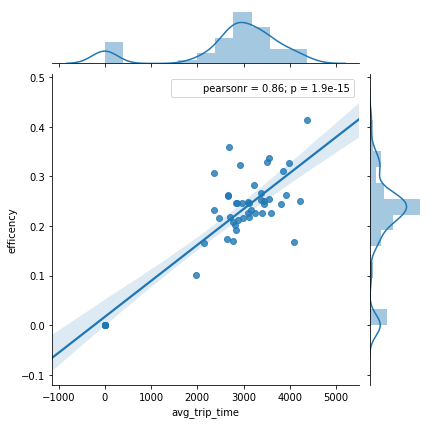

In [80]:
sns.jointplot(x='avg_trip_time', y='efficency', 
              data=df5, kind='reg');